# IMPORT NECESSARY LIBRARIES

In [315]:
# Standard libraries
import re
from collections import Counter

# Text processing
import spacy

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [316]:
# Load spaCy model (English in this case)
nlp = spacy.load("en_core_web_sm")

## DATA LOADING

In [317]:
# Load the dataset from a CSV file
df = pd.read_csv('/Users/m1/Downloads/Annotated_NLP.csv')

# Display the first few rows of the dataset and summary
print(df.head())
print(df.info())

# Check for missing values
print(df.isnull().sum())


     id               Name        Date           Title  \
0  6414              Memee  09/08/2024  lovely quality   
1  6415             Folake  09/08/2024            good   
2  6416  Abayomi Olowosoyo  09/08/2024       Very good   
3  6417            oladipo  05/08/2024        Thumb up   
4  6418             Sharon  16/07/2024         Like it   

                          text  Rating  \
0  Came as seen. Good product!       5   
1    It's a very nice material       4   
2                         Nice       5   
3       portable & comfortable       4   
4                    Beautiful       5   

                                         Product_url              label  
0  https://www.jumia.com.ng/vejaro-bc003-infant-b...           Positive  
1  https://www.jumia.com.ng/vejaro-bc003-infant-b...  Slightly Negative  
2  https://www.jumia.com.ng/vejaro-bc003-infant-b...           Positive  
3  https://www.jumia.com.ng/fashion-womens-diamon...  Slightly Negative  
4  https://www.jumia.com.ng/

# DATA PREPROCESSING

In [318]:
# Remove duplicates and handle missing values
# text column contains review and the relevant column for this analysis
# Label column contains the annotated sentiments from Doccano 

df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
df = df.dropna(subset=['text', 'label'])

# Standardize text fields to lowercase
df['text'] = df['text'].str.lower()


In [319]:
# Function to clean and tokenize text using spaCy
def clean_and_tokenize(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Remove stop words, punctuation and non-alphabetic tokens
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text, tokens

In [320]:
# Apply the cleaning and tokenization function to the 'text'(reviews) column
df['cleaned_text'], df['tokens'] = zip(*df['text'].apply(clean_and_tokenize))

# Display the first few rows of the cleaned and tokenized data
print(df[['text', 'cleaned_text', 'tokens']].head())

                          text            cleaned_text  \
0  came as seen. good product!  came seen good product   
1    it's a very nice material           nice material   
2                         nice                    nice   
3       portable & comfortable    portable comfortable   
4                    beautiful               beautiful   

                        tokens  
0  [came, seen, good, product]  
1             [nice, material]  
2                       [nice]  
3      [portable, comfortable]  
4                  [beautiful]  


# EXPLORATORY DATA ANALYSIS

In [321]:
# Visualize label distribution
# Calculate the distribution of sentiment labels
label_distribution = df['label'].value_counts().reset_index()
label_distribution.columns = ['Sentiment', 'Number of Reviews']

# Interactive bar chart using Plotly
fig = px.bar(label_distribution, 
             x='Sentiment', 
             y='Number of Reviews', 
             title='Distribution of Sentiment Labels',
             labels={'Sentiment': 'Sentiment', 'Number of Reviews': 'Number of Reviews'},
             color='Sentiment',
             color_discrete_sequence=['Green', 'LightGreen', 'orange', 'Tomato', 'Red'])

# Show interactive plot
fig.show()


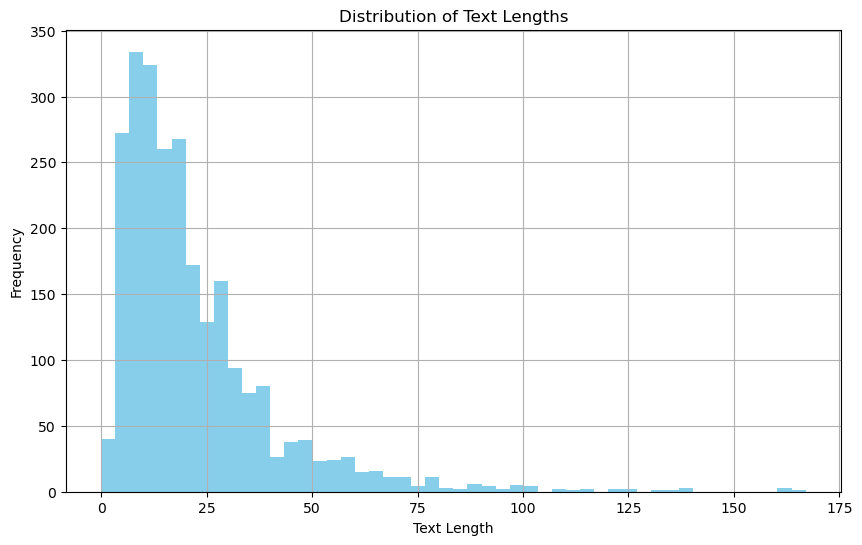

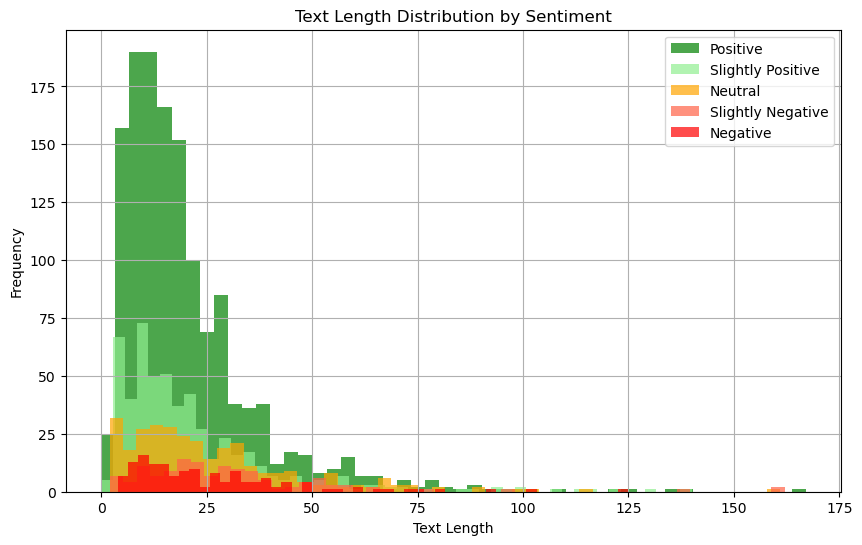

In [322]:
# Distribution of text length
df['text_length'] = df['cleaned_text'].apply(len)
plt.figure(figsize=(10, 6))
df['text_length'].hist(bins=50, color='skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Define the colors for each sentiment
colors = {
    'Positive': 'green',
    'Slightly Positive': 'lightgreen',
    'Neutral': 'orange',
    'Slightly Negative': 'tomato',
    'Negative': 'red'
}

plt.figure(figsize=(10, 6))

# Plot histograms for each sentiment label
for label, color in colors.items():
    df[df['label'] == label]['text_length'].hist(bins=50, color=color, alpha=0.7, label=label)

plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()



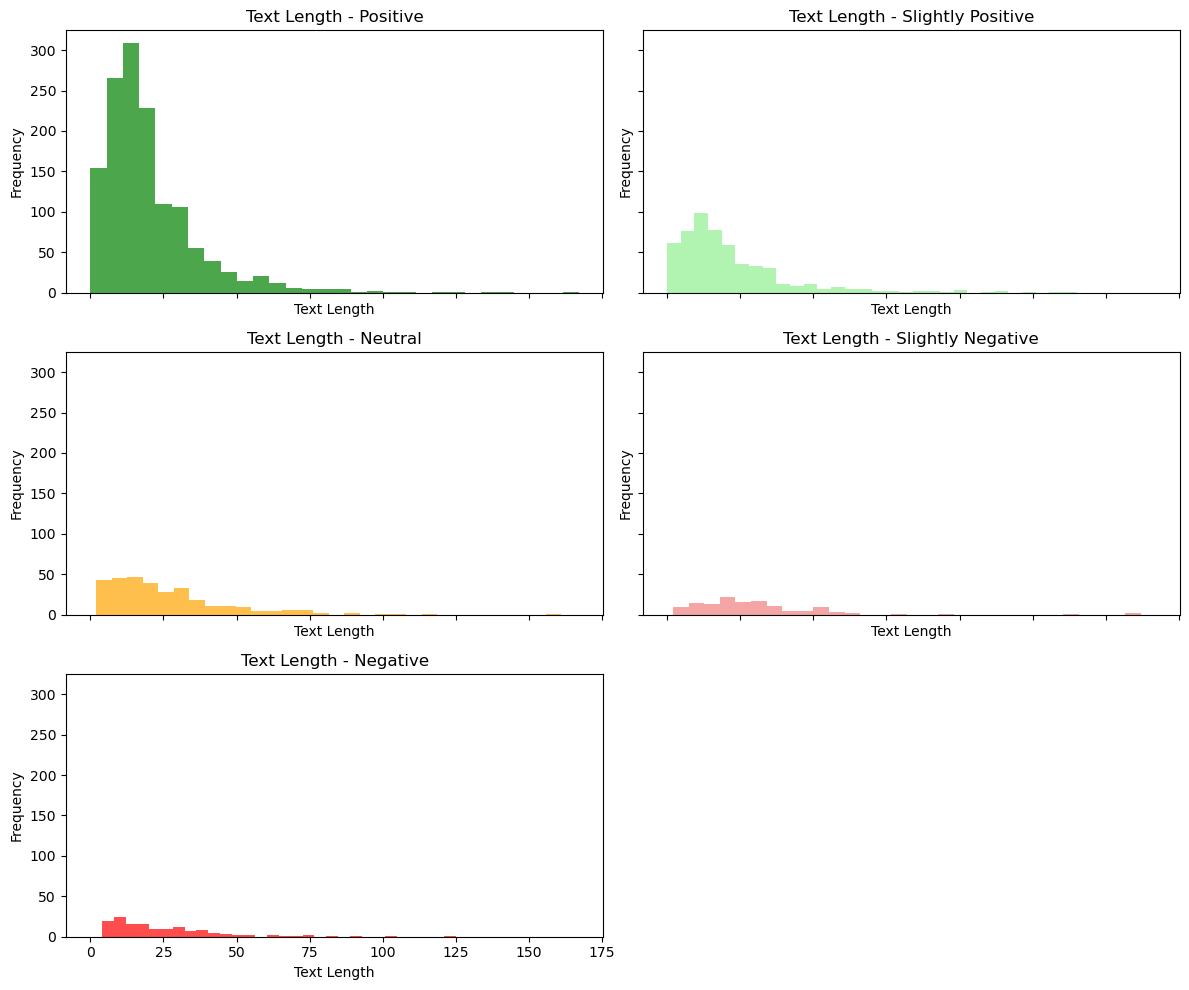

In [323]:
# Distribution of text length across sentiment data using subplots

# Define the colors for each sentiment
colors = {
    'Positive': 'green',
    'Slightly Positive': 'lightgreen',
    'Neutral': 'orange',
    'Slightly Negative': 'lightcoral',
    'Negative': 'red'
}

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each sentiment label in separate subplots
for ax, (label, color) in zip(axes, colors.items()):
    ax.hist(df[df['label'] == label]['text_length'], bins=30, color=color, alpha=0.7)
    ax.set_title(f'Text Length - {label}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

# Remove the empty subplot if labels < 6
if len(colors) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [324]:
# Word Frequency and Visualization
# Display the 10 most common words
all_tokens = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_tokens)
print(word_freq.most_common(10))

[('good', 422), ('quality', 323), ('nice', 301), ('love', 208), ('size', 189), ('like', 163), ('exactly', 128), ('beautiful', 126), ('product', 121), ('material', 111)]


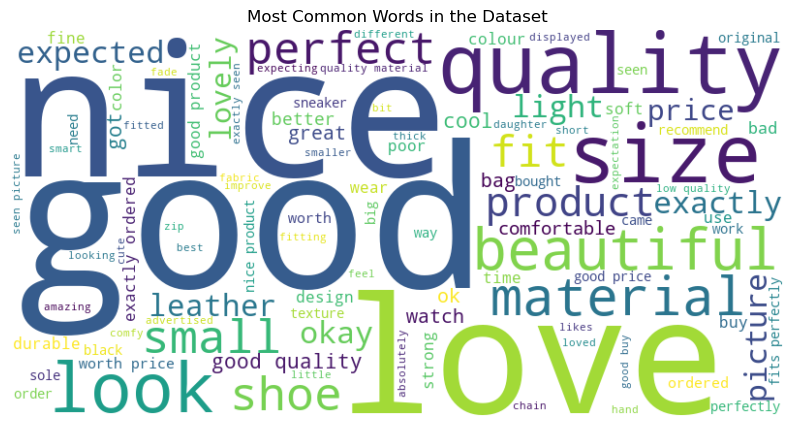

In [325]:
# Visualize most frequent words
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(df['cleaned_text']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()

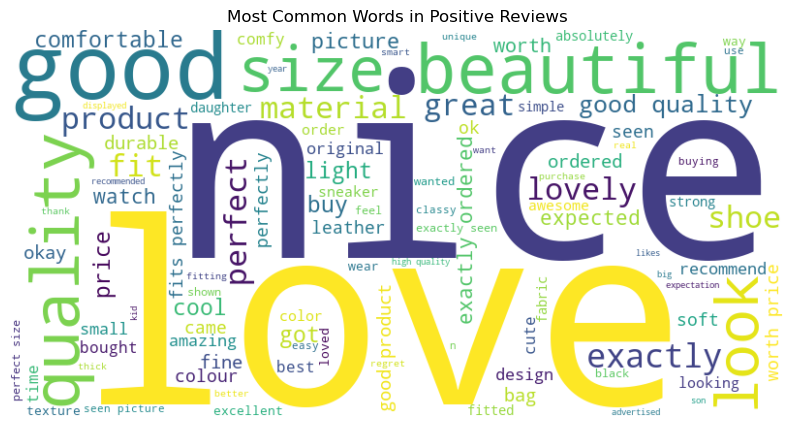

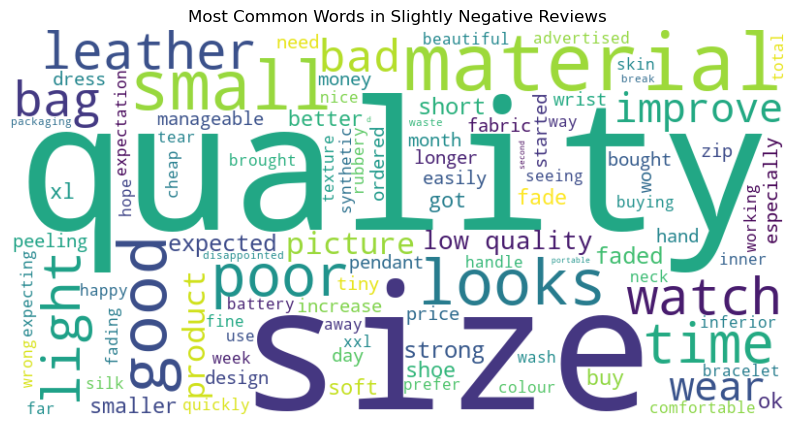

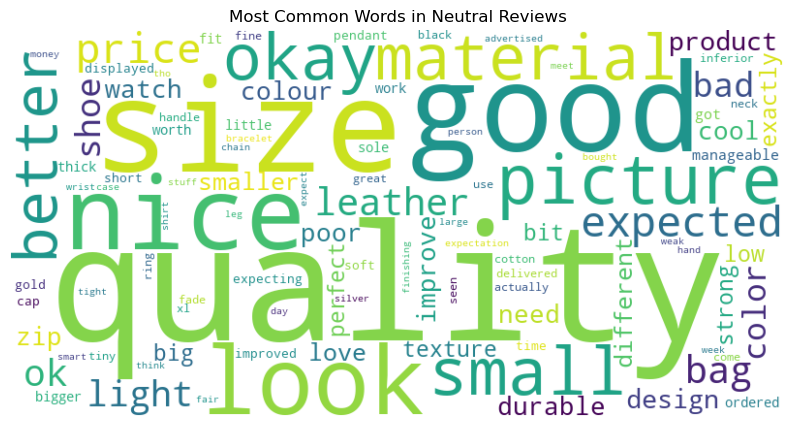

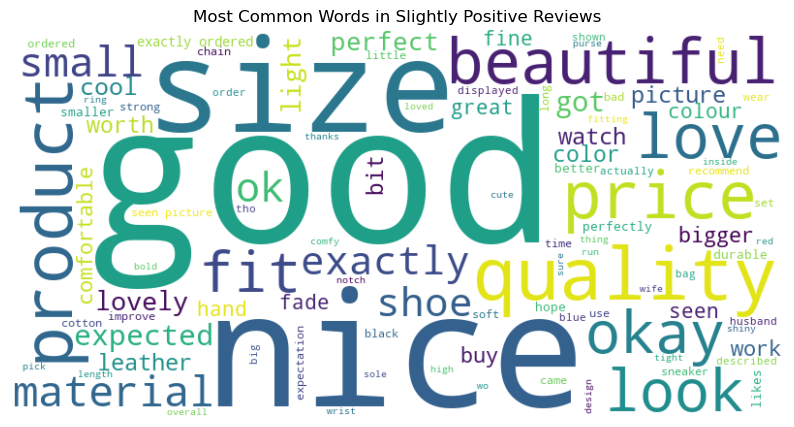

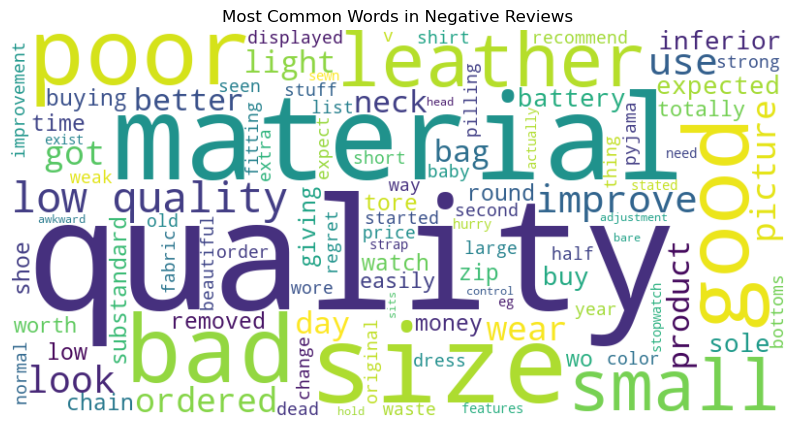

In [326]:
# Word Cloud for each Sentiment Class
for sentiment in df['label'].unique():
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(df[df['label'] == sentiment]['cleaned_text']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {sentiment} Reviews')
    plt.show()

## HANDLING CLASS IMBALANCE

In [327]:
# Upsample Minority size
majority_class_size = df['label'].value_counts().max()

# Create an empty list to store the upsampled DataFrames
upsampled_dfs = []

# Loop through each class and upsample if it's smaller than the majority class size
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    if len(df_class) < majority_class_size:
        df_class_upsampled = resample(df_class, 
                                      replace=True, 
                                      n_samples=majority_class_size, 
                                      random_state=42)
    else:
        df_class_upsampled = df_class
    upsampled_dfs.append(df_class_upsampled)

# Combine all the upsampled classes into one DataFrame
df_upsampled = pd.concat(upsampled_dfs)

# Check the new class distribution
print(df_upsampled['label'].value_counts())

Positive             1367
Slightly Negative    1367
Neutral              1367
Slightly Positive    1367
Negative             1367
Name: label, dtype: int64


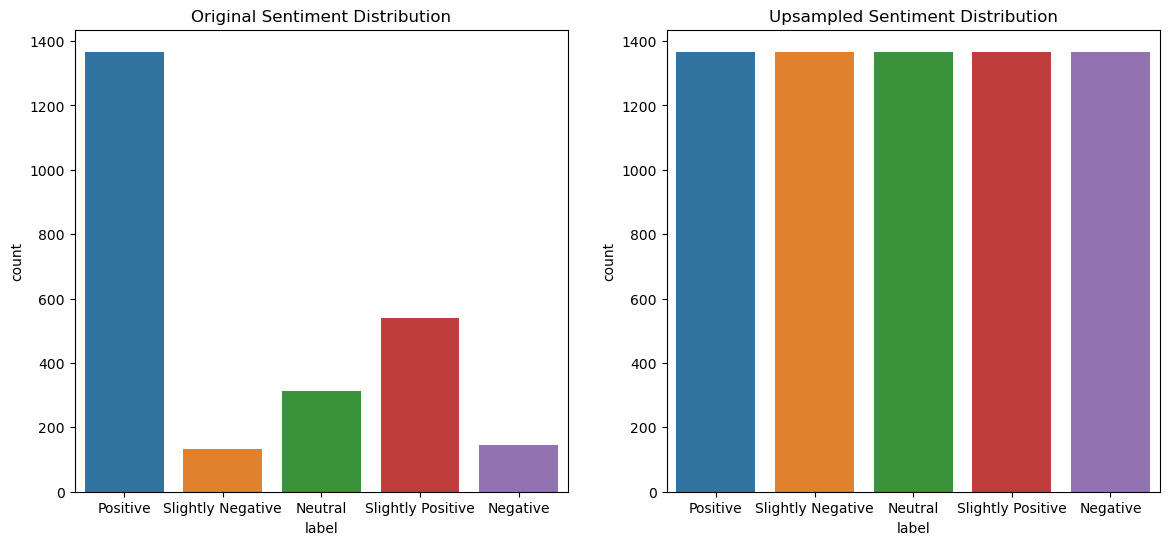

In [338]:
# Class Imbalance Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x='label', data=df, ax=ax[0])
ax[0].set_title('Original Sentiment Distribution')
sns.countplot(x='label', data=df_upsampled, ax=ax[1])
ax[1].set_title('Upsampled Sentiment Distribution')
plt.show()

# FEATURE EXTRACTION

In [329]:
# Feature extraction using Bag-of-Words (BOW)
# Using unigrams and bigrams to capture both individual words and word pairs.
# The max_features parameter limits the number of features to 5,000 most frequent terms.
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')

# Fit the vectorizer to the cleaned text and transform the data into a feature matrix
X_bow = count_vectorizer.fit_transform(df_upsampled['cleaned_text'])

# Convert the feature matrix to a DataFrame for easier inspection
bow_df = pd.DataFrame(X_bow.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display the first few rows of the Bag-of-Words feature matrix
print(bow_df.head())

   able  able wear  abrasive  abrasive hash  absolutely  absolutely beautiful  \
0     0          0         0              0           0                     0   
1     0          0         0              0           0                     0   
2     0          0         0              0           0                     0   
3     0          0         0              0           0                     0   
4     0          0         0              0           0                     0   

   absolutely love  absolutely lovely  accessories  accessories tarnishes  \
0                0                  0            0                      0   
1                0                  0            0                      0   
2                0                  0            0                      0   
3                0                  0            0                      0   
4                0                  0            0                      0   

   ...  zipper  zipper bad  zipper main  zipper pr

In [330]:
# Encode the target labels as integers
label_encoder = LabelEncoder()
y_upsampled_encoded = label_encoder.fit_transform(df_upsampled['label'])

In [331]:
# Split the data into training and testing sets using the BoW features
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y_upsampled_encoded, test_size=0.2, random_state=42)

# Double-check the shapes
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train_bow: (5468, 5000)
Shape of y_train: (5468,)
Shape of X_test_bow: (1367, 5000)
Shape of y_test: (1367,)


# Model Building and Evaluation
## Multinomial Naive Bayes

Naive Bayes with BoW Accuracy: 0.7739575713240673
Naive Bayes with BoW Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       283
           1       0.73      0.81      0.77       253
           2       0.68      0.68      0.68       278
           3       0.88      0.82      0.85       280
           4       0.74      0.66      0.70       273

    accuracy                           0.77      1367
   macro avg       0.77      0.77      0.77      1367
weighted avg       0.77      0.77      0.77      1367



<Figure size 600x600 with 0 Axes>

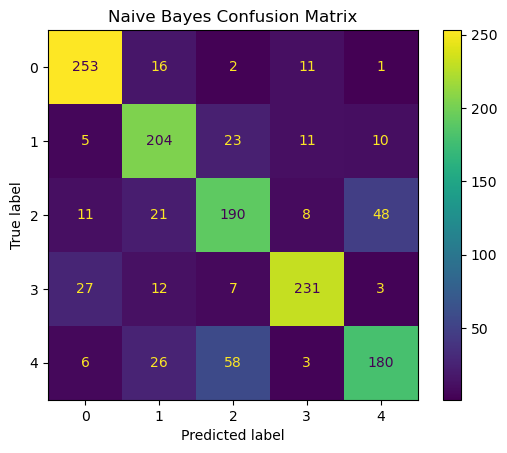

In [332]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model with BoW features
nb_model.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_bow = nb_model.predict(X_test_bow)

# Evaluate the model
print(f"Naive Bayes with BoW Accuracy: {accuracy_score(y_test, y_pred_bow)}")
print("Naive Bayes with BoW Classification Report:")
print(classification_report(y_test, y_pred_bow))

# Naive Bayes Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test_bow, y_test)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

## Support Vector Machine (SVM)

SVM Accuracy: 0.8354059985369422
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       283
           1       0.87      0.82      0.84       253
           2       0.69      0.80      0.74       278
           3       0.95      0.90      0.92       280
           4       0.80      0.68      0.73       273

    accuracy                           0.84      1367
   macro avg       0.84      0.83      0.83      1367
weighted avg       0.84      0.84      0.83      1367



<Figure size 600x600 with 0 Axes>

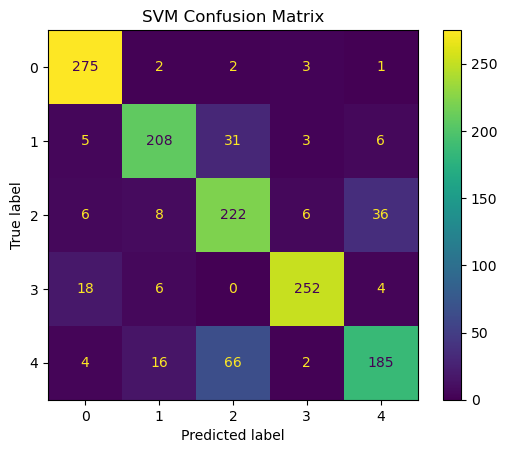

In [333]:
# Initialize the model
svm_model = SVC()

# Train the model
svm_model.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_bow)

# Evaluate the model
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# SVM Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_bow, y_test)
plt.title("SVM Confusion Matrix")
plt.show()


## Logistic Regression

Logistic Regression Accuracy: 0.84491587417703
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       283
           1       0.82      0.87      0.84       253
           2       0.84      0.65      0.73       278
           3       0.94      0.92      0.93       280
           4       0.71      0.83      0.77       273

    accuracy                           0.84      1367
   macro avg       0.85      0.84      0.84      1367
weighted avg       0.85      0.84      0.84      1367



<Figure size 600x600 with 0 Axes>

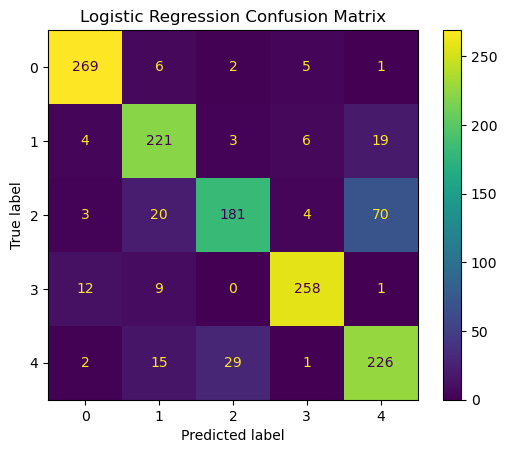

In [334]:
# Scale the training and testing data
scaler = StandardScaler(with_mean=False)
X_train_bow_scaled = scaler.fit_transform(X_train_bow)
X_test_bow_scaled = scaler.transform(X_test_bow)

# Initialize the Logistic Regression model with more iterations
logistic_model = LogisticRegression(max_iter=1000)

# Train the model with scaled data
logistic_model.fit(X_train_bow_scaled, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test_bow_scaled)

# Evaluate the model
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logistic)}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# Logistic Regression Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_bow_scaled, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## XGBOOST

XGBoost Accuracy: 0.7644476956839795
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       283
           1       0.74      0.75      0.74       253
           2       0.63      0.71      0.67       278
           3       0.93      0.88      0.90       280
           4       0.68      0.56      0.61       273

    accuracy                           0.76      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.76      0.76      0.76      1367



<Figure size 600x600 with 0 Axes>

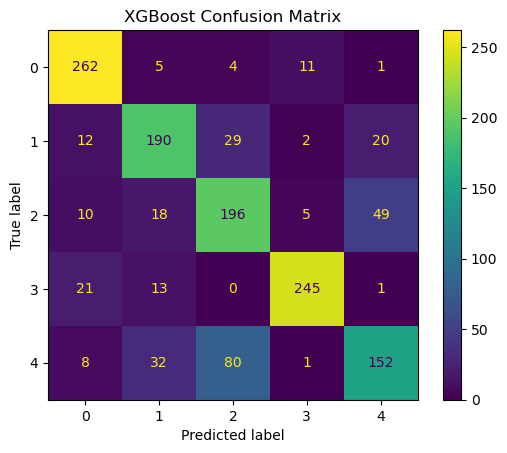

In [335]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

# Train the model with encoded labels
xgb_model.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_bow)

# Evaluate the model
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# XGBoost Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_bow, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

In [336]:
# Summarize model performances
# For Naive Bayes
nb_accuracy = accuracy_score(y_test, y_pred_bow)
nb_report = classification_report(y_test, y_pred_bow, output_dict=True)
nb_precision = nb_report['weighted avg']['precision']
nb_recall = nb_report['weighted avg']['recall']
nb_f1 = nb_report['weighted avg']['f1-score']

# For SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)  # Calculate accuracy
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)
svm_precision = svm_report['weighted avg']['precision']
svm_recall = svm_report['weighted avg']['recall']
svm_f1 = svm_report['weighted avg']['f1-score']

# For Logistic Regression
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)  # Calculate accuracy
logistic_report = classification_report(y_test, y_pred_logistic, output_dict=True)
logistic_precision = logistic_report['weighted avg']['precision']
logistic_recall = logistic_report['weighted avg']['recall']
logistic_f1 = logistic_report['weighted avg']['f1-score']

# For XGBoost
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)  # Calculate accuracy
xgb_precision = xgb_report['weighted avg']['precision']
xgb_recall = xgb_report['weighted avg']['recall']
xgb_f1 = xgb_report['weighted avg']['f1-score']

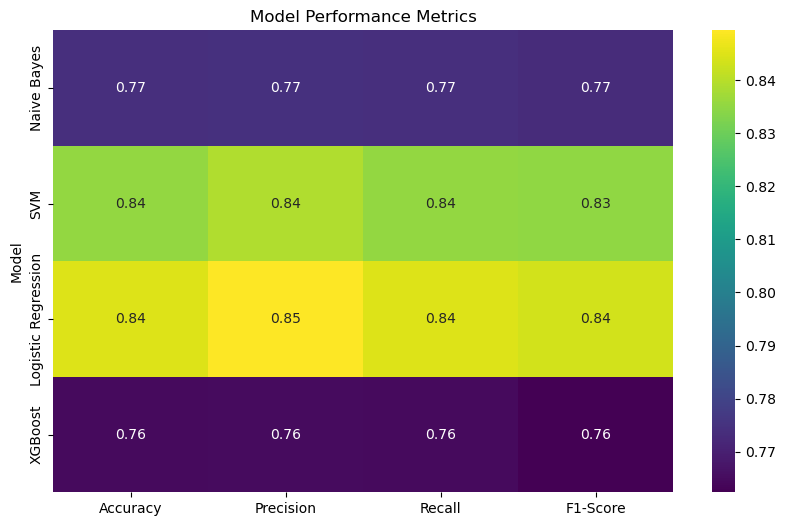

In [337]:
# Create a dictionary with all the metrics
metrics = {
    'Model': ['Naive Bayes', 'SVM', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [nb_accuracy, svm_accuracy, logistic_accuracy, xgb_accuracy],
    'Precision': [nb_precision, svm_precision, logistic_precision, xgb_precision],
    'Recall': [nb_recall, svm_recall, logistic_recall, xgb_recall],
    'F1-Score': [nb_f1, svm_f1, logistic_f1, xgb_f1]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

# Create a heatmap to visualize the metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='viridis', fmt='.2f')

# Add a title to the heatmap
plt.title('Model Performance Metrics')
plt.show()